In [ ]:
%pip install pythtb

In [1]:
# Importing necessary libraries
from pythtb import *
import matplotlib.pyplot as plt

# Initializing the Wannier90 model by reading the data files
pgda=w90(r"PdGa_Ham2",r"wannier90")
my_model=pgda.model(min_hopping_norm=0.01) # only hoppings with norm greater than 0.01 are considered

# Task 1

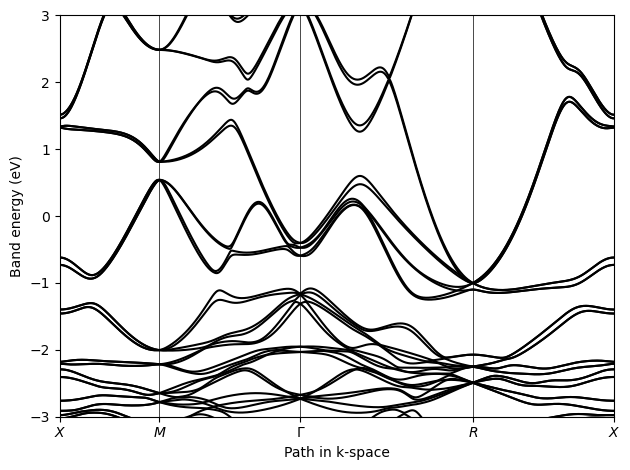

In [2]:
# Choosing the path
path=[[0.5,0.0,0.0],[0.5,-0.5,0.0],[0.0,0.0, 0.0],[0.5,0.5,0.5],[0.5,0.0,0.0]]
k_label=(r'$X$', r'$M$', r'$\Gamma$', r'$R$', r'$X$')
(k_vec,k_dist,k_node)=my_model.k_path(path,1001,report=False)

# Finding the energy eigenvalues at all k-points
evals=my_model.solve_all(k_vec)
energies = evals - 6.87 # Subtructing the Fermi energy

# Plotting the bands
fig, ax = plt.subplots()
for i in range(evals.shape[0]):
    ax.plot(k_dist,energies[i],"k-")
for n in range(len(k_node)):
    ax.axvline(x=k_node[n],linewidth=0.5, color='k')
ax.set_xlabel("Path in k-space")
ax.set_ylabel("Band energy (eV)")
ax.set_xlim(k_dist[0],k_dist[-1])
ax.set_ylim(-3, 3)
ax.set_xticks(k_node)
ax.set_xticklabels(k_label)
fig.tight_layout()

plt.show()

# Task 2

In [3]:
# To write the band velocity operator at a k-point
def calculate_v_euler_forward(k_vec, dk=0.01):
    H = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]])
    Hx = my_model._gen_ham([k_vec[0]+dk, k_vec[1], k_vec[2]])
    Hy = my_model._gen_ham([k_vec[0], k_vec[1]+dk, k_vec[2]])
    Hz = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]+dk])

    vx = (Hx-H)/dk
    vy = (Hy-H)/dk
    vz = (Hz-H)/dk
    return np.array((vx, vy, vz))

In [4]:
# using euler backward method
def calculate_v_euler_backward(k_vec, dk=0.01):
    H = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]])
    Hx = my_model._gen_ham([k_vec[0]-dk, k_vec[1], k_vec[2]])
    Hy = my_model._gen_ham([k_vec[0], k_vec[1]-dk, k_vec[2]])
    Hz = my_model._gen_ham([k_vec[0], k_vec[1], k_vec[2]-dk])

    vx = (H-Hx)/dk
    vy = (H-Hy)/dk
    vz = (H-Hz)/dk

    return np.array((vx, vy, vz))

In [5]:
# To get energy eigenvalues and corresponding OAMs at a k-point
def solve_and_calculate_L(k_vec, eta=0.01):
    v = calculate_v_euler_backward(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    
    # Getting energy eigenvalues and vectors
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    # Calculating 3 components of OAM
    Lx = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[2]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[2]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lx[n] = np.imag(temp)
    Ly = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[2]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[2]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Ly[n] = np.imag(temp)
    Lz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lz[n] = np.imag(temp)
    return (eig_values, np.array((Lx, Ly, Lz)))

In [6]:
# Choosing the path
path=[[-0.5,-0.5,-0.5],[0.0,0.0, 0.0],[0.5,0.5,0.5]]
k_label=(r'$R$', r'$\Gamma$', r'$R$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)

# Calculating OAM
evals = np.zeros((64, k_vec.shape[0]))
L = np.zeros((3, 64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], L[:,:, i]) = solve_and_calculate_L(k_vec[i])
    if i%50 == 0:
        print(i+1, "points done.")

energies = evals-6.87
colors = L[0]+L[1]+L[2]     # L_111

1 points done.
51 points done.
101 points done.
151 points done.
201 points done.
251 points done.
301 points done.
351 points done.
401 points done.
451 points done.
501 points done.


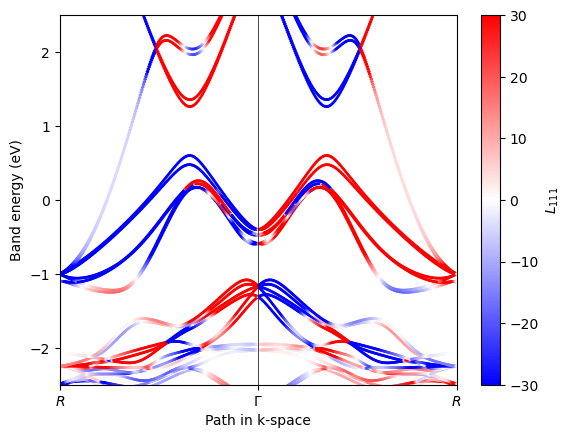

In [7]:
# Plotting
plt.set_cmap('bwr')
cmax = 30
for i in range(evals.shape[0]):
    plt.scatter(k_dist, energies[i], s=1, c=colors[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$L_{111}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-2.5, 2.5)
plt.xticks(k_node, labels=k_label)
plt.show()

# Task 3


$j^z_x=\frac{1}{2} \left\{ v_x,L_z \right\}$

$\Omega^{z}_{n,xy}=-2 Im \sum_{m \neq n}\frac{ \langle n(k)|j^{z}_{x}|m(k)\rangle \langle m(k)|v_{y}|n(k)\rangle}{( E_n(k)-E_m(k))^2}$

In [ ]:
# To get energy eigenvalues and corresponding OBC (Omega^z_xy) at a k-point
def solve_and_calculate_Omega_xyz(k_vec, eta=0.0001):
    v = calculate_v_euler_backward(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    # Calculating L_z
    Lz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lz[n] = np.imag(temp)
    
    # Calculating Omega^z_xy
    Omega_xyz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp -= (Lz[m]+Lz[n])*(eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))**2
        Omega_xyz[n] = np.imag(temp/2)
    return (eig_values, Omega_xyz)

In [9]:
# Choosing the path
path=[[0.0,0.0, 0.0],[0.5,0.0, 0.0],[0.5,0.5,0.0],[0.0,0.0, 0.0],[0.5,0.5,0.5],[0.5,0.0, 0.0]]
k_label=(r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$', r'$R$', r'$X$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)

# Calculating OBC
evals = np.zeros((64, k_vec.shape[0]))
Omega_xyz = np.zeros((64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], Omega_xyz[:, i]) = solve_and_calculate_Omega_xyz(k_vec[i])
    if i%100 == 0:
        print(i+1, "points done.")

colors = Omega_xyz
energies = evals -6.87

1 points done.
101 points done.
201 points done.
301 points done.
401 points done.
501 points done.


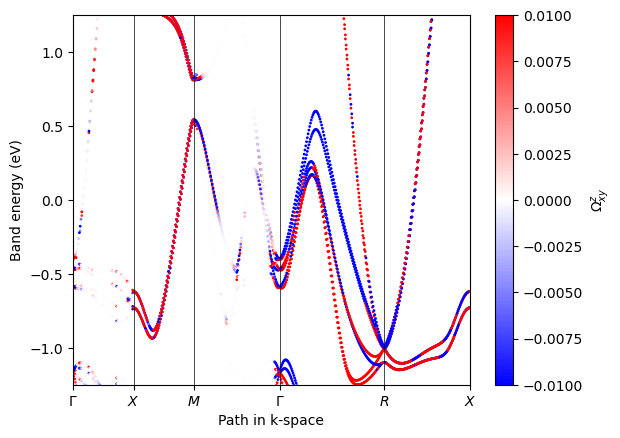

In [10]:
# Plotting
cmax = 0.01
plt.set_cmap('bwr')
for i in range(energies.shape[0]):
    plt.scatter(k_dist,energies[i], s=1, c=Omega_xyz[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$\\Omega^z_{xy}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-1.25, 1.25)
plt.xticks(k_node, labels=k_label)
plt.show()

In [11]:
# for forward method
# To get energy eigenvalues and corresponding OBC (Omega^z_xy) at a k-point
def solve_and_calculate_Omega_xyz(k_vec, eta=0.0001):
    v = calculate_v_euler_forward(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    # Calculating L_z
    Lz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp += (eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
            temp -= (eig_vectors[n].conjugate().dot(v[1]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[0]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))
        Lz[n] = np.imag(temp)
    
    # Calculating Omega^z_xy
    Omega_xyz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp -= (Lz[m]+Lz[n])*(eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))**2
        Omega_xyz[n] = np.imag(temp/2)
    return (eig_values, Omega_xyz)

In [12]:
# Choosing the path
path=[[0.0,0.0, 0.0],[0.5,0.0, 0.0],[0.5,0.5,0.0],[0.0,0.0, 0.0],[0.5,0.5,0.5],[0.5,0.0, 0.0]]
k_label=(r'$\Gamma$', r'$X$', r'$M$', r'$\Gamma$', r'$R$', r'$X$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)

# Calculating OBC
evals = np.zeros((64, k_vec.shape[0]))
Omega_xyz = np.zeros((64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], Omega_xyz[:, i]) = solve_and_calculate_Omega_xyz(k_vec[i])
    if i%100 == 0:
        print(i+1, "points done.")

colors = Omega_xyz
energies = evals -6.87

1 points done.
101 points done.
201 points done.
301 points done.
401 points done.
501 points done.


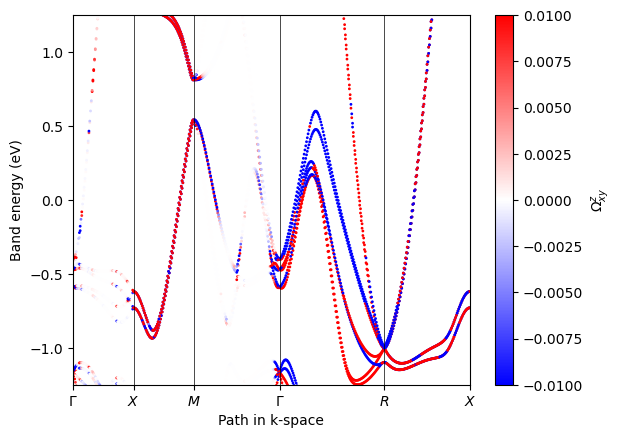

In [13]:
# Plotting
cmax = 0.01
plt.set_cmap('bwr')
for i in range(energies.shape[0]):
    plt.scatter(k_dist,energies[i], s=1, c=Omega_xyz[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$\\Omega^z_{xy}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-1.25, 1.25)
plt.xticks(k_node, labels=k_label)
plt.show()

# Supplementary

In [ ]:
# Choosing the path
path=[[-0.5,-0.5,-0.0],[0.0,0.0, 0.0],[0.5,0.5,0.0]]
k_label=(r'$M$', r'$\Gamma$', r'$M$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)

# Calculating OAM
evals = np.zeros((64, k_vec.shape[0]))
L = np.zeros((3, 64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], L[:,:, i]) = solve_and_calculate_L(k_vec[i])
    if i%100 == 0:
        print(i+1, "points done.")

energies = evals-6.87
colors = L[0] + L[1]

In [ ]:
# Plotting
plt.set_cmap('bwr')
cmax = 30
for i in range(evals.shape[0]):
    plt.scatter(k_dist, energies[i], s=1, c=colors[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$L_{110}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-2.5, 2.5)
plt.xticks(k_node, labels=k_label)
plt.show()

In [16]:
# Choosing the path
path=[[0.0,0.0,-0.5],[0.0,0.0,0.0],[0.0,0.0,0.5]]
k_label=(r'$Z$', r'$\Gamma$',r'$Z$')
(k_vec,k_dist,k_node)=my_model.k_path(path,501,report=False)

# Calculating OAM
evals = np.zeros((64, k_vec.shape[0]))
L = np.zeros((3, 64, k_vec.shape[0]))
for i in range(k_vec.shape[0]):
    (evals[:, i], L[:,:, i]) = solve_and_calculate_L(k_vec[i])
    if i%50 == 0:
        print(i+1, "points done.")

energies = evals-6.87
colors = L[0]+L[1]+L[2]     # L_111

1 points done.


KeyboardInterrupt: 

In [ ]:
# Plotting
plt.set_cmap('bwr')
cmax = 30
for i in range(evals.shape[0]):
    plt.scatter(k_dist, energies[i], s=1, c=colors[i])
    plt.clim(-cmax, cmax)
plt.colorbar(label="$L_{111}$")
for n in range(len(k_node)):
    plt.axvline(x=k_node[n],linewidth=0.5, color='k')
plt.xlabel("Path in k-space")
plt.ylabel("Band energy (eV)")
plt.xlim(k_dist[0],k_dist[-1])
plt.ylim(-2.5, 2.5)
plt.xticks(k_node, labels=k_label)
plt.show()

In [1]:
# defining hamiltonian
import numpy as np
import math
# angular momentum for Ga ( p-obital)
Lz_Ga = [[0,0,0],[0,0,-1j],[0,1j,0]]
Lx_Ga = [[0,0,0],[0,0,-1j],[0,1j,0]]
Ly_Ga = [[0,0,1j],[0,0,0],[-1j,0,0]]

# angular momentum for Pd ( d-obital)
Lz_Pd = [[0,0,0,0,0],[0,0,-1j,0,0],[0,1j,0,0,0],[0,0,0,0,-2j],[0,0,0,2j,0]]
Ly_Pd = [[0,-1j,0,0,0],[1j,0,0,0,-1j],[0,0,0,-1j*math.sqrt(3),0],[0,0,1j*math.sqrt(3),0,0],[0,1j,0,0,0]]
Lx_Pd = [[0,0,1j,0,0],[0,0,0,0,-1j],[-1j,0,0,-1j*math.sqrt(3),0],[0,0,1j*math.sqrt(3),0,0],[0,1j,0,0,0]]

In [37]:
def L_matrix(L_Ga, L_Pd, choice_of_xyz):

    if choice_of_xyz == 'x':

        Lx_Pd = np.tile(L_Pd[0], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Lx_Ga = np.tile(L_Ga[0], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Lx = np.zeros((32, 32), dtype=complex)
        Lx[0:20, 0:20] = Lx_Pd
        Lx[20:32, 20:32] = Lx_Ga
        Lx = np.kron(np.eye(2), Lx)

        return Lx
    
    elif choice_of_xyz == 'y':
        Ly_Pd = np.tile(L_Pd[1], (4, 4))  # Duplicate the Lz_Pd matrix 4 times
        Ly_Ga = np.tile(L_Ga[1], (4, 4))  # Duplicate the Lz_Ga matrix 4 times
        
        Ly = np.zeros((32, 32), dtype=complex)
        Ly[0:20, 0:20] = Ly_Pd
        Ly[20:32, 20:32] = Ly_Ga
        Ly = np.kron(np.eye(2), Ly)

        return Ly
    
    Lz_Pd = np.tile(Lz_Pd, (4, 4))  # Duplicate the Lz_Pd matrix 4 times
    Lz_Ga = np.tile(Lz_Ga, (4, 4))  # Duplicate the Lz_Ga matrix 4 times
    
    Lz = np.zeros((32, 32), dtype=complex)
    Lz[0:20, 0:20] = Lz_Pd
    Lz[20:32, 20:32] = Lz_Ga
    Lz = np.kron(np.eye(2), Lz)

    return Lz 

In [38]:
L_Ga = [Lx_Ga, Ly_Ga, Lz_Ga ]
L_Pd = [Lx_Pd, Ly_Pd, Lz_Pd ]
choice_of_xyz = 'x'
result = L_matrix(L_Ga, L_Pd, choice_of_xyz)


$j^z_x=\frac{1}{2} \left\{ v_x,L_z \right\}$

$\Omega^{z}_{n,xy}=-2 Im \sum_{m \neq n}\frac{ \langle n(k)|j^{z}_{x}|m(k)\rangle \langle m(k)|v_{y}|n(k)\rangle}{( E_n(k)-E_m(k))^2}$

In [ ]:
# To get energy eigenvalues and corresponding OBC (Omega^z_xy) at a k-point
def solve_and_calculate_Omega_xyz(k_vec, eta=0.0001):
    v = calculate_v_euler_backward(k_vec)                  # velocity using forward finite difference
    #v = my_model.derivative_ham(k_vec)     # velocity using exact derivative formula
    (eig_values, eig_vectors) = my_model.solve_one(k_vec, eig_vectors=True)
    
    # Calculating L_z
    Lz = L_matrix(L_Ga, L_Pd, choice_of_xyz = 'z')
    
    # Calculating Omega^z_xy
    Omega_xyz = np.zeros(eig_values.shape[0])
    for n in range(eig_values.shape[0]):
        temp = 0
        for m in range(eig_values.shape[0]):
            if m==n:
                continue
            temp -= (Lz[m]+Lz[n])*(eig_vectors[n].conjugate().dot(v[0]).dot(eig_vectors[m])*eig_vectors[m].conjugate().dot(v[1]).dot(eig_vectors[n]))/(eig_values[n]-eig_values[m]+complex(0,eta))**2
        Omega_xyz[n] = np.imag(temp/2)
    return (eig_values, Omega_xyz)